In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import seaborn as sns

print("Pandas version: {}".format(pd.__version__))
print("NumPy version: {}".format(np.__version__))

Pandas version: 2.2.3
NumPy version: 2.1.1


In [3]:
result_dir = "../case-study/datacenter"
fig_dir = "./figures"

In [5]:
df_summary = pd.read_csv(f"{result_dir}/summary_metrics.csv")
df_summary

,DateTime,Extractor,Folder,Interface,Throughput,Runtime (s),Avg_CPU_Usage (%),Avg_Memory_Usage (MB),Max_Memory_Usage (MB),CPU Cores,CPU Logical Cores,Total Memory (MB),Available Memory (MB)
0,2025-02-05 09:11:15,rustiflow,/data/rustiflow,eno3,NaN,89258.781116,64.494639,156.725145,175.039062,16,32,128868.382812,124797.277344


In [60]:
df_resources = pd.read_csv(f"{result_dir}/rustiflow_realtime_metrics.csv")
df_resources_24h = df_resources.iloc[:86400]
df_resources_24h

,Interval,CPU_Usage (%),Memory_Usage (MB),CPU_Num,Num_Threads,Open_Files,Context_Switches,Child Processes
0,1,0.0,5.421875,[0],1,0,3,0
1,2,0.0,90.777344,"[0, 31]",34,0,43,1
2,3,51.5,91.339844,"[0, 31]",34,0,43,1
3,4,39.6,91.339844,"[0, 31]",34,0,43,1
4,5,37.6,91.593750,"[0, 31]",34,0,43,1
...,...,...,...,...,...,...,...,...
86395,86396,72.2,175.039062,"[0, 31]",34,0,43,1
86396,86397,75.1,175.039062,"[0, 31]",34,0,43,1
86397,86398,36.6,175.039062,"[0, 31]",34,0,43,1
86398,86399,11.9,175.039062,"[0, 31]",34,0,43,1


In [70]:
df_resources_5s = (
    df_resources[["CPU_Usage (%)", "Memory_Usage (MB)"]]
    .groupby(df_resources.index.astype(int) // 5)
    .mean()
)
df_resources_5s

,CPU_Usage (%),Memory_Usage (MB)
0,25.74,74.094531
1,93.86,92.682812
2,51.28,94.330469
3,53.42,95.019531
4,43.90,96.538281
...,...,...
17643,18.00,175.039062
17644,14.62,175.039062
17645,22.56,175.039062
17646,17.60,175.039062


In [18]:
df_network = pd.read_csv(f"{result_dir}/ifstat.log", delim_whitespace=True, skiprows=1)
df_network.columns = ["time", "rx", "tx"]
df_network_24h = df_network.iloc[:17280]
df_network_24h

/tmp/ipykernel_300680/3457578461.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_network = pd.read_csv(f"{result_dir}/ifstat.log", delim_whitespace=True, skiprows=1)


,time,rx,tx
0,09:11:20,12669.17,0.0
1,09:11:25,28143.37,0.0
2,09:11:30,15534.90,0.0
3,09:11:35,20500.37,0.0
4,09:11:40,18430.54,0.0
...,...,...,...
17275,09:12:24,190380.40,0.0
17276,09:12:29,174139.80,0.0
17277,09:12:34,179867.30,0.0
17278,09:12:39,154523.50,0.0


In [19]:
df_network_24h.describe()

,rx,tx
count,17280.000000,17280.0
mean,67276.758927,0.0
std,62774.438114,0.0
min,1572.040000,0.0
25%,6088.080000,0.0
50%,55002.740000,0.0
75%,115516.425000,0.0
max,395351.800000,0.0


In [ ]:
# KB/s averaged over 5s (one datapoint per 5s) -> summed and multiplied by 5 to get total KB
df_network_24h["rx"].sum()

np.float64(1162542394.2500002)

# Plot CPU and Memory in function of time

In [142]:
max_value = df_network["rx"].rolling(window=60).mean().max()
max_index = df_network["rx"].rolling(window=60).mean().idxmax()
max_index, max_value

(11368, np.float64(177166.34833333333))

In [161]:
max_cpu_value = df_resources_5s["CPU_Usage (%)"].rolling(window=12 * 5).mean().max()
max_cpu_index = df_resources_5s["CPU_Usage (%)"].rolling(window=12 * 5).mean().idxmax()
max_cpu_index, max_cpu_value

(np.int64(11247), np.float64(135.73366666666666))

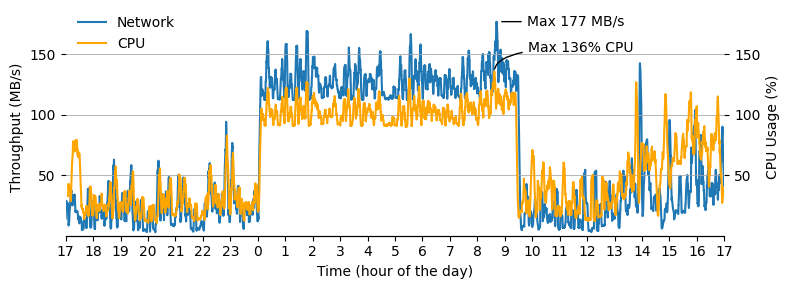

In [214]:
fig, ax1 = plt.subplots(figsize=(8, 3))
ax1.plot(
    df_network.index - 60,  # 5min offset to compensate for slower start of rustiflow
    df_network["rx"].rolling(window=5*12).mean(),
    label="Network",
)
ax1.annotate(
    "Max {:.0f} MB/s".format(max_value / 1000),
    (max_index, max_value),
    textcoords="offset points",
    xytext=(20, 0),
    ha="left",
    va="center",
    arrowprops=dict(arrowstyle="-"), #, color='C0'),
    size="medium",
    # color='C0'
)

ax1.set_xticks(range(0, len(df_network["time"]) + 1, 12 * 60))  # 1 hour
ax1.set_xticklabels(
    [(17 + (i * 5) // 3600)%24 for i in range(0, len(df_network["time"]) + 1, 12 * 60)]
)
ax1.set_xlim(0, 17280)  # each point is 5 seconds -> 24 hours = 17280 points
ax1.set_xlabel("Time (hour of the day)")
ax1.set_ylim(0, 180000)
ax1.set_ylabel("Throughput (MB/s)")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1000:.0f}"))
ax1.set_yticks([50_000, 100_000, 150_000])

ax2 = ax1.twinx()

df_resources_5s["CPU_Usage (%)"].rolling(window=12 * 5).mean().plot(color="orange", ax=ax2, label="CPU")
ax2.annotate(
    "Max {:.0f}% CPU".format(max_cpu_value),
    (max_cpu_index, max_cpu_value),
    textcoords="offset points",
    xytext=(24, 17),
    ha="left",
    va="center",
    arrowprops=dict(arrowstyle="-", connectionstyle="angle3,angleA=0,angleB=90"), #, color='C1'),
    size="medium",
    # color='C1'
)

ax2.set_xlim(0, 17280)  # each point is 5 seconds -> 24 hours = 17280 points
ax2.set_ylim(0, 180)
ax2.set_ylabel("CPU Usage (%)")
ax2.set_yticks([50, 100, 150])

# Collect handles and labels for the legend
handles, labels = [], []
for ax in [ax1, ax2]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

for ax in [ax1, ax2]:
    ax.yaxis.grid(True, linewidth=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)

ax1.legend(handles, labels, loc="upper left", frameon=False, bbox_to_anchor=(0.0, 1.07))

plt.tight_layout()
plt.savefig(f'{fig_dir}/datacenter_24h_cpu_throughput.pdf', bbox_inches='tight')
plt.show()

# Analyze the flows

In [5]:
# Step 1: Define column types (optional, but recommended)
dtypes = {
    "IP_SOURCE": "object",
    "IP_DESTINATION": "object",
    "FIRST_TIMESTAMP": "object",
    "FWD_PKT_LEN_TOT": "int32",
    "BWD_PKT_LEN_TOT": "int32",
    "FWD_PACKET_COUNT": "int32",
    "BWD_PACKET_COUNT": "int32",
    "FLOW_PACKET_LENGTH_MEAN": "float32",
}

# Step 2: Read in chunks (if processing is needed)
chunksize = 500_000  # Adjust based on available memory
chunks = pd.read_csv(
    "/mnt/d/RustiFlow/datacenter/rustiflow_realtime.csv",
    dtype=dtypes,
    chunksize=chunksize,
)

# Process each chunk (Example: appending them together)
df_list = []
for chunk in chunks:
    df_list.append(chunk)

df = pd.concat(df_list, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8944554 entries, 0 to 8944553
Data columns (total 85 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   FLOW_ID                      object 
 1   IP_SOURCE                    object 
 2   PORT_SOURCE                  int64  
 3   IP_DESTINATION               object 
 4   PORT_DESTINATION             int64  
 5   PROTOCOL                     int64  
 6   FIRST_TIMESTAMP              object 
 7   LAST_TIMESTAMP               object 
 8   DURATION                     int64  
 9   FWD_PACKET_COUNT             int32  
 10  BWD_PACKET_COUNT             int32  
 11  FWD_PKT_LEN_TOT              int32  
 12  BWD_PKT_LEN_TOT              int32  
 13  FWD_PKT_LEN_MAX              int64  
 14  FWD_PKT_LEN_MIN              int64  
 15  FWD_PKT_LEN_MEAN             float64
 16  FWD_PKT_LEN_STD              float64
 17  BWD_PKT_LEN_MAX              int64  
 18  BWD_PKT_LEN_MIN              int64  
 19  

In [ ]:
# Still u32 overflows happening here
df[["FWD_PKT_LEN_TOT", "BWD_PKT_LEN_TOT", "FWD_PACKET_COUNT", "BWD_PACKET_COUNT"]].describe()

,FWD_PKT_LEN_TOT,BWD_PKT_LEN_TOT,FWD_PACKET_COUNT,BWD_PACKET_COUNT
count,8.944554e+06,8.944554e+06,8.944554e+06,8.944554e+06
mean,2.387266e+04,1.945029e+04,3.871300e+02,2.123297e+02
std,6.287237e+06,7.601212e+06,2.569224e+05,1.051301e+05
min,-1.992018e+09,-2.147355e+09,1.000000e+00,0.000000e+00
25%,1.560000e+02,1.410000e+02,1.000000e+00,1.000000e+00
50%,1.710000e+02,2.910000e+02,2.000000e+00,2.000000e+00
75%,3.420000e+02,5.460000e+02,4.000000e+00,4.000000e+00
max,2.137746e+09,2.137742e+09,2.667484e+08,2.645494e+08


In [12]:
max_fwd_packet_count_row = df[df["FWD_PACKET_COUNT"] > 2.66748e+08]
max_fwd_packet_count_row[
    [
        "FLOW_ID",
        "IP_SOURCE",
        "PORT_SOURCE",
        "IP_DESTINATION",
        "PORT_DESTINATION",
        "PROTOCOL",
        "FIRST_TIMESTAMP",
        "LAST_TIMESTAMP",
        "DURATION",
        "FWD_PACKET_COUNT",
        "BWD_PACKET_COUNT",
        "FWD_PKT_LEN_TOT",
        "BWD_PKT_LEN_TOT",
    ]
]

,FLOW_ID,IP_SOURCE,PORT_SOURCE,IP_DESTINATION,PORT_DESTINATION,PROTOCOL,FIRST_TIMESTAMP,LAST_TIMESTAMP,DURATION,FWD_PACKET_COUNT,BWD_PACKET_COUNT,FWD_PKT_LEN_TOT,BWD_PKT_LEN_TOT
4509329,10.2.47.2:35587-10.2.32.9:264-6,10.2.47.2,35587,10.2.32.9,264,6,2025-02-06 04:15:29.107969582 UTC,2025-02-06 05:15:30.107962798 UTC,3600999993,266748430,41937377,-840551216,984526390


In [14]:
unique_source_ips = df["IP_SOURCE"].nunique()
unique_destination_ips = df["IP_DESTINATION"].nunique()

unique_source_ips, unique_destination_ips

(18023, 7767)

In [9]:
df["FIRST_TIMESTAMP"] = pd.to_datetime(df["FIRST_TIMESTAMP"])
df["FIRST_TIMESTAMP"].describe()

count                                8944554
mean     2025-02-06 04:53:47.242083072+00:00
min      2025-02-05 16:11:16.438194617+00:00
25%      2025-02-05 22:12:24.443421184+00:00
50%      2025-02-06 05:06:02.866194944+00:00
75%      2025-02-06 11:35:23.909068288+00:00
max      2025-02-06 16:58:54.377505310+00:00
Name: FIRST_TIMESTAMP, dtype: object